# Dynamic Time Warping to align participant and expert movement

In [1]:
import json
import pandas as pd
import numpy as np
from pandas import json_normalize

from scipy import stats

from dtaidistance import dtw_ndim
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from workout_dataset import WorkoutDataset

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import statistics
import os

# Parameters

In [2]:
# code of participant; used for loading raw data and naming results file
participant = "P1"
# used only for loading raw data
screenLocation = "Expert-anchored"

# file path to raw data
file_path = "./src/workOutData_"+participant+"_"+screenLocation+".csv"

# which tracked positions will be used for the DTW
relevant_positions = ['shoulder', 'hip', 'elbow', 'wrist', 'hip', 'knee', 'ankle']
# which tracked positions will be used to compute results
relevant_comparisons = ['shoulder', 'elbow', 'hip', 'knee']

# perform DTW or simply use a 1-to-1 mapping
use_dtw = True
# apply z normalization before performing DTW
use_z_score = True
# window length of the DTW
window_length = 1000
# plot the result of the warping for each dimenison
plot_warpings = True

# Load data

In [3]:
workout_dataset = WorkoutDataset(relevant_positions, relevant_comparisons)
workout_dataset.load_data(file_path)

In [4]:
workout_dataset.analysis_variables

['shoulder_l_angle',
 'shoulder_r_angle',
 'elbow_l_angle',
 'elbow_r_angle',
 'hip_l_angle',
 'hip_r_angle',
 'knee_l_angle',
 'knee_r_angle']

In [5]:
workout_dataset.warping_variables

['shoulder_l_position',
 'shoulder_r_position',
 'elbow_l_position',
 'elbow_r_position',
 'wrist_l_position',
 'wrist_r_position',
 'hip_l_position',
 'hip_r_position',
 'knee_l_position',
 'knee_r_position',
 'ankle_l_position',
 'ankle_r_position']

# Multidimensional Time Warping
See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5668684/ for difference between DTW_D and DTW_I

## Calculation of DTW_D


In [6]:
# custom warping plotting method that allows custom number of alignment lines

number_of_alignment_lines = 40
def plot_warping(s1, s2, path, filename=None, title=None):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex='all', sharey='all')
    if title is not None:
        fig.suptitle(title)
    ax[0].plot(s1)
    ax[1].plot(s2)
    plt.tight_layout()
    lines = []
    line_options = {'linewidth': 0.5, 'color': 'orange', 'alpha': 0.8}
    draw_count = -1
    draw_every_xth_path = int(len(path) / number_of_alignment_lines)
    for r_c, c_c in path:
        draw_count = (draw_count + 1) % draw_every_xth_path
        if draw_count > 0:
            continue
        if r_c < 0 or c_c < 0:
            continue
        con = ConnectionPatch(xyA=[r_c, s1[r_c]], coordsA=ax[0].transData,
                              xyB=[c_c, s2[c_c]], coordsB=ax[1].transData, **line_options)
        lines.append(con)
    for line in lines:
        fig.add_artist(line)
    if filename:
        plt.savefig(filename)
        plt.close()
        fig, ax = None, None
    return fig, ax

In [7]:
def calculate_z_scores(dataset_a, dataset_b):
    #find constant columns (i.e. columns that contain a single value) as calculating the z score fails on them
    constant_a = dataset_a.columns[dataset_a.nunique() <= 1]
    constant_b = dataset_b.columns[dataset_b.nunique() <= 1]
    
    #align dataset columns
    a_aligned = dataset_a
    b_aligned = dataset_b[a_aligned.columns]
    
    a_z = a_aligned.apply(stats.zscore)
    b_z = b_aligned.apply(stats.zscore)
    
    for constant_column in constant_a:
        a_z[constant_column] = a_z[constant_column].fillna(0)
        
    for constant_column in constant_b:
        b_z[constant_column] = b_z[constant_column].fillna(0)
    
    a_np = a_aligned.to_numpy()
    b_np = b_aligned.to_numpy()

    a_z_np = a_z.to_numpy()
    b_z_np = b_z.to_numpy()
    
    return a_np, b_np, a_z_np, b_z_np, a_aligned.columns

def calculate_warping(dataset_a, dataset_b):
    a_np, b_np, a_z_np, b_z_np, columns = calculate_z_scores(dataset_a, dataset_b)
    
    if not use_z_score:
        a_z_np = a_np[:, 1]
        b_z_np = b_np[:, 1]
        
    if use_dtw:
        d, paths = dtw_ndim.warping_paths(a_z_np, b_z_np, window=window_length)
        best_path = dtw.best_path(paths)
        dtwvis.plot_warpingpaths(a_np[:, 1], b_np[:, 1], paths, best_path)
        plt.show()
    else:
        best_path = [(i, i) for i in range(len(a_z_np))]
    
    # plot warping for each dimension
    if plot_warpings:
        display(Markdown("## Warping for each dimension")) 
        for dim in range(a_np.shape[1]):
            s1 = a_np[:,dim]
            s2 = b_np[:,dim]

            plot_warping(s1, s2, best_path, title=columns[dim])
            plt.show()
    else:
        display(Markdown("(skipped plot of warping, set `plot_warpings = true` to enable it)")) 
        
    return best_path

In [8]:
# saves a warping path along with the corresponding angles for both participant and trainer
def save_warping_with_angles(warping_path, angles_reference, angles_user, file_name):
    output_table = pd.DataFrame()
    output_table['reference'] = np.resize([warp_pair[0] for warp_pair in warping_path], len(warping_path))
    output_table['user'] = np.resize([warp_pair[1] for warp_pair in warping_path], len(warping_path))
    
    for column in angles_reference.columns:
        angle_reference = angles_reference[column]
        angle_user = angles_user[column]
    
        angle_reference_np = angle_reference.to_numpy()
        angle_user_np = angle_user.to_numpy()
        
        warped_angle_df = pd.DataFrame({'reference_{}'.format(column): [], 'user_{}'.format(column): []})
        for path_tuple in warping_path:
            angle_of_reference = angle_reference_np[path_tuple[0]]
            angle_of_user = angle_user_np[path_tuple[1]]
            
            warped_angle_df.loc[len(warped_angle_df.index)] = [angle_of_reference, angle_of_user]
            
        output_table = output_table.join(warped_angle_df)
        
    output_table.to_csv(file_name, mode='w', index=False, header=True)

# Warping for Expert-anchored

- use Dynamic Time Warping: **True** 
- use z-normalization: **True**

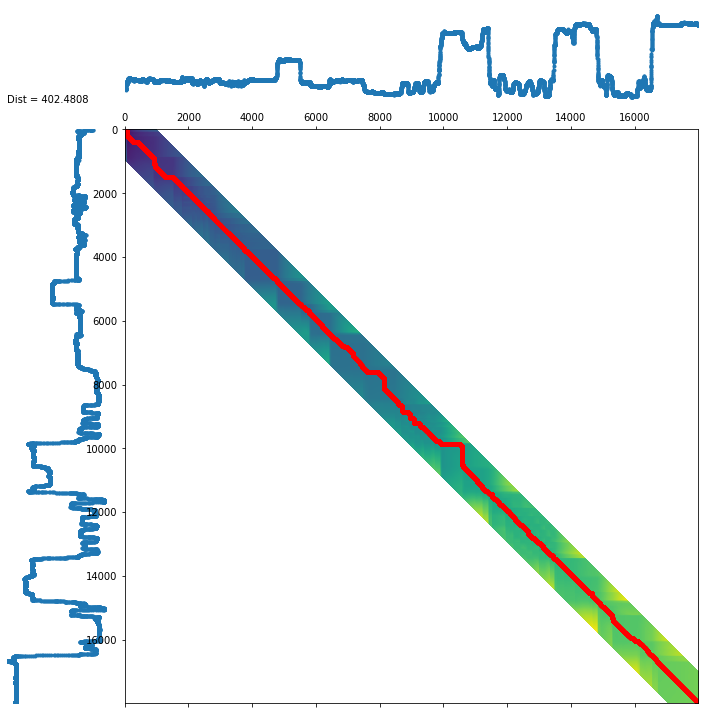

## Warping for each dimension

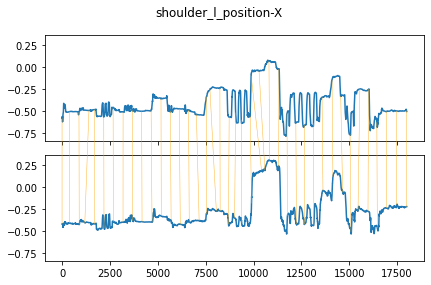

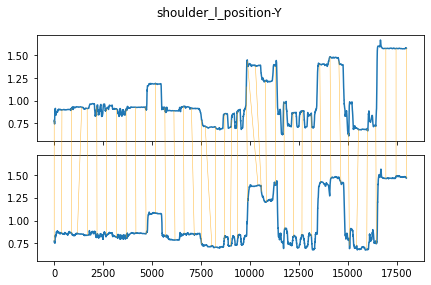

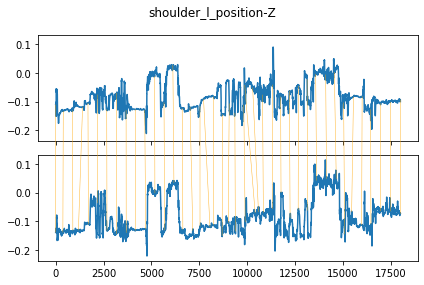

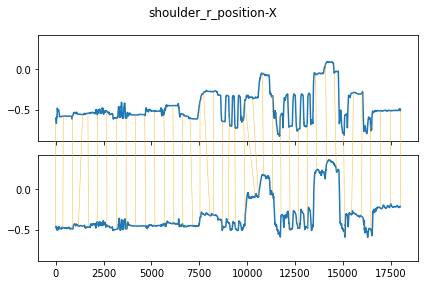

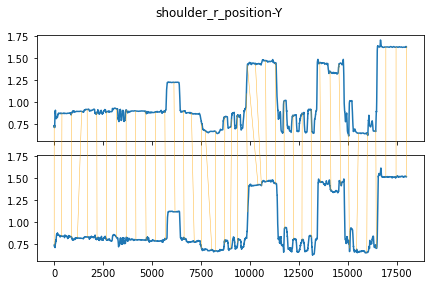

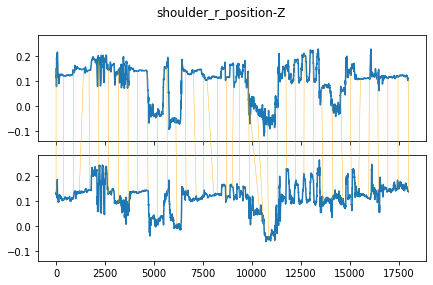

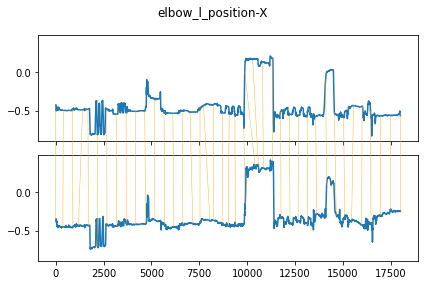

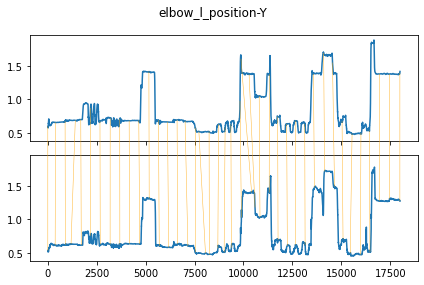

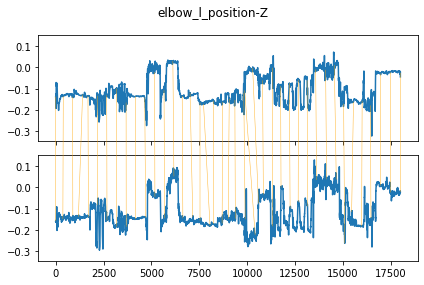

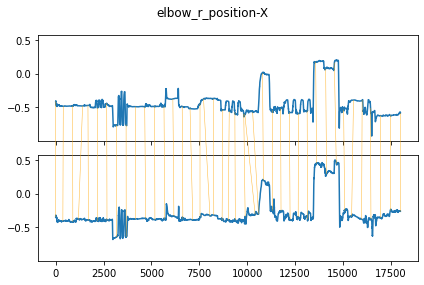

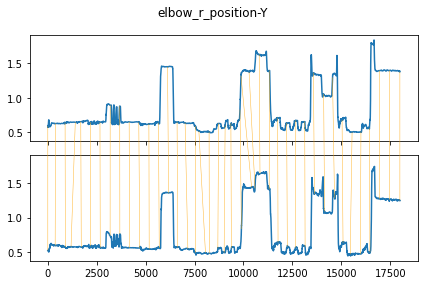

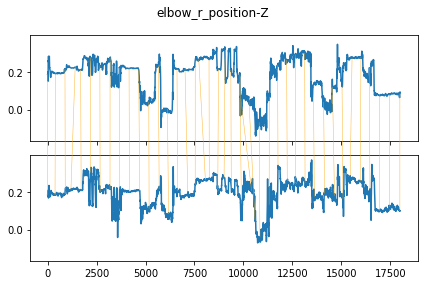

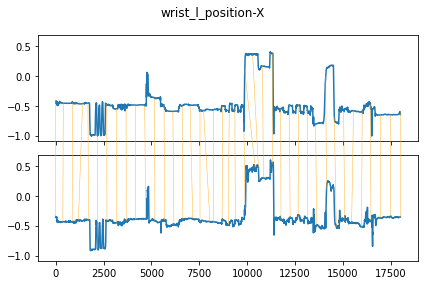

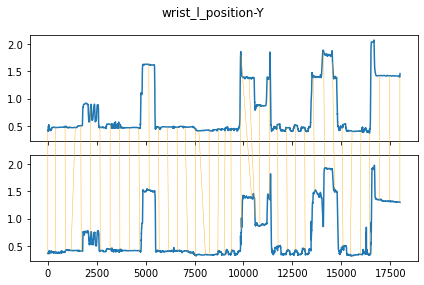

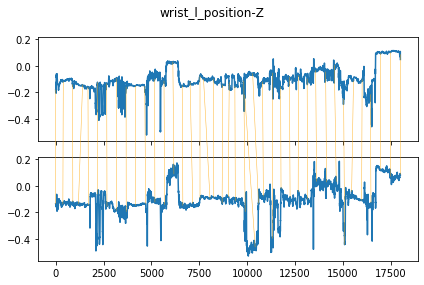

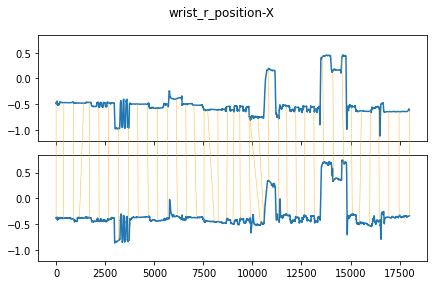

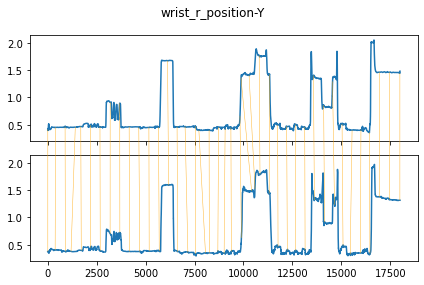

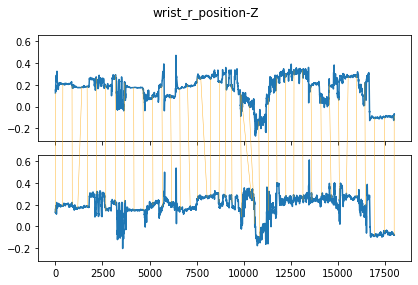

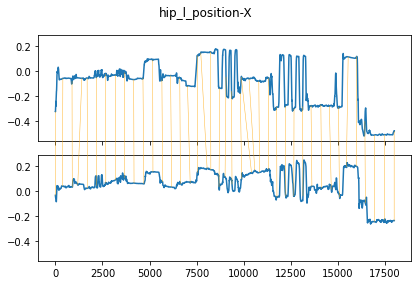

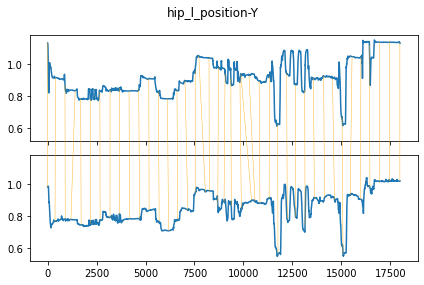

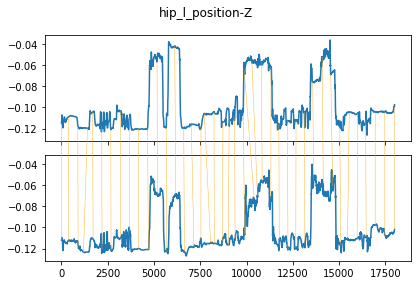

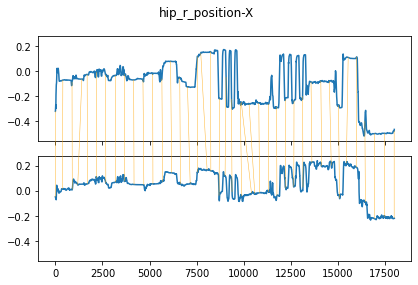

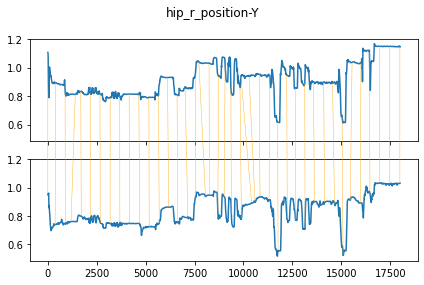

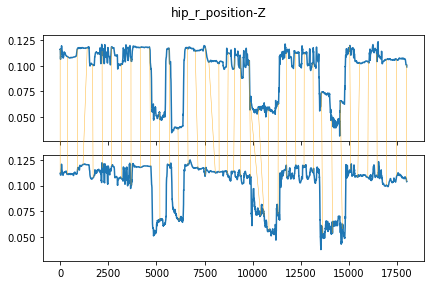

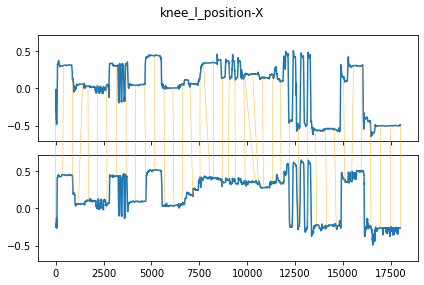

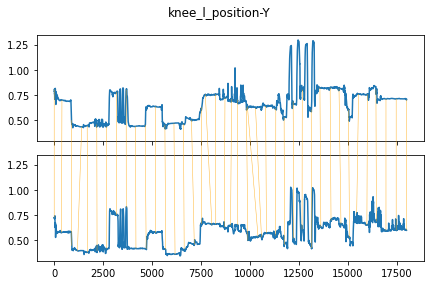

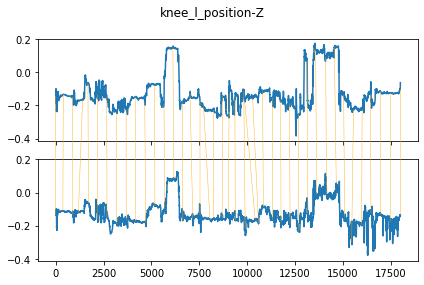

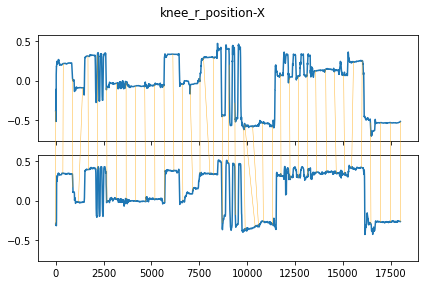

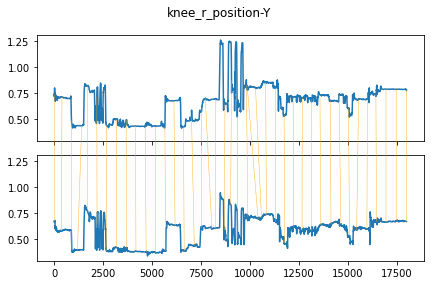

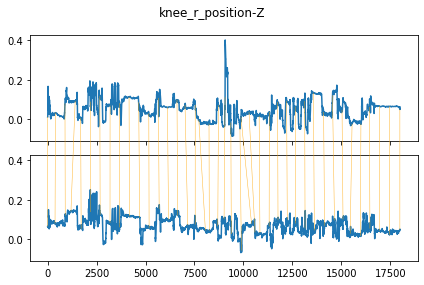

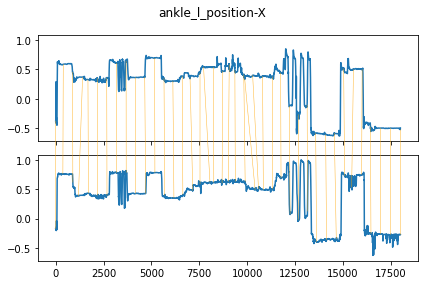

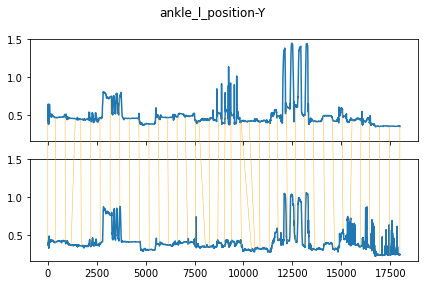

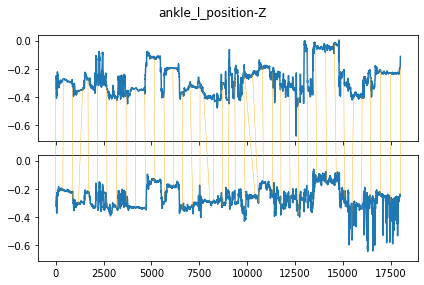

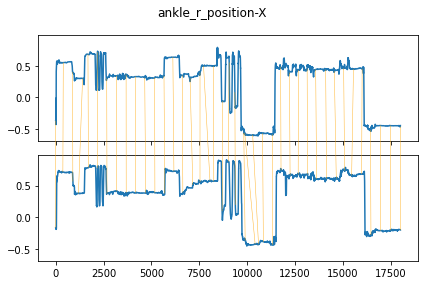

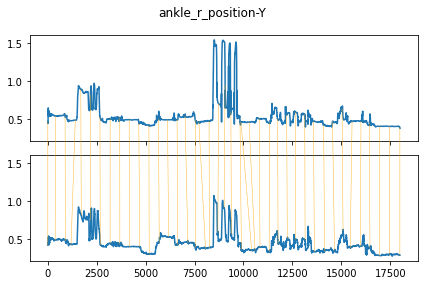

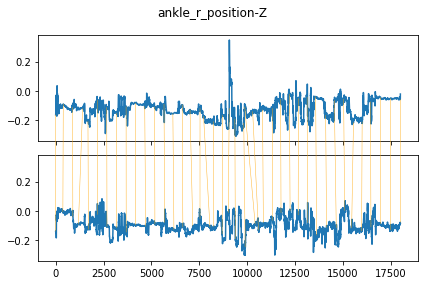

saved warping file to `./output/P1_Expert-anchored_warping.csv`

---

In [9]:
difference_reports = {}
for mode_name in workout_dataset.data_by_mode.keys():
    display(Markdown("# Warping for {}".format(mode_name)))
    display(Markdown("- use Dynamic Time Warping: **{}** \n- use z-normalization: **{}**".format(use_dtw, use_z_score)))
    
    column_names = workout_dataset.select_column_names(time_warping_included=True, comparison_included=False)

    user_mode_data = workout_dataset.compile_dataset(mode_name, column_names, from_user=True)
    expert_mode_data = workout_dataset.compile_dataset(mode_name, column_names, from_user=False)
    
    warping_path = calculate_warping(expert_mode_data, user_mode_data)
    
    file_path = "./output/{}_{}_warping.csv".format(participant, mode_name)
    
    angle_column_names = workout_dataset.select_column_names(time_warping_included=False, comparison_included=True)
    user_mode_angle_data = workout_dataset.compile_dataset(mode_name, angle_column_names, from_user=True)
    expert_mode_angle_data = workout_dataset.compile_dataset(mode_name, angle_column_names, from_user=False)
    
    save_warping_with_angles(warping_path, expert_mode_angle_data, user_mode_angle_data, file_path)
    
    display(Markdown("saved warping file to `{}`".format(file_path)))
    display(Markdown("---"))
    